<a href="https://colab.research.google.com/github/Jinstronda/research-papers-pytorch/blob/main/Pytorch_FoodVision_Transfer_Learning_Efficient_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import requests # Downloading My Tools
import os
file_path = "pytorch_tools.py"
url = ("https://raw.githubusercontent.com/Jinstronda/Personal-Projects/refs/heads/main/pytorch_utils/pytorch_tools.py")
response = requests.get(url)
if os.path.exists(file_path):
  print("Already Downloaded!")
else:
  with open("pytorch_tools.py", "wb") as file:
    file.write(response.content)

    print("Download complete: pytorch_tools.py")


Already Downloaded!


In [15]:
from pytorch_tools import *

In [16]:
setup_torch_env("torchvision")

✅ PyTorch environment setup complete!


In [17]:
device = "gpu" if torch.cuda.is_available() else "cpu"

# Get Data

In [18]:
while False:
  !wget https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip
  !unzip pizza_steak_sushi.zip -d ./data/

In [19]:
from pytorch_tools import create_dataloaders
train_dir = "/content/data/train"
test_dir = "/content/data/test"
import torchvision

In [20]:
# Getting Pre Trained Weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Default = Best Available
auto_transforms = weights.transforms()
my_transform = transforms.Compose([
    auto_transforms
])

In [21]:
BATCH_SIZE = 32



train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    train_transform = my_transform,
    test_transform = my_transform,
    batch_size = BATCH_SIZE
)


In [22]:
class_names
test_dataloader

# Setting Up a Pre-Trained Model

In [23]:
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [24]:
model.classifier # Needs to be changed to 3 ouputs, we gonna train only on the last layer

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [25]:
# Print a summary of Model
from torchinfo import summary
summary(model=model,
        input_size=(1,3,224,224),
        col_names= ["input_size","output_size","num_params","trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

## Frezing the Base Model
We are gonna keep the feature extraction frozen and just train the last classification layer

In [26]:
model.features # Only the Feature Extraction Layers

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [27]:
for param in model.features.parameters():
  param.requires_grad = False

In [28]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names= ["input_size","output_size","num_params","trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

In [29]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=3,bias=True)
).to(device)
model.classifier # Updating The Classifier Layer To Only 3 Classes.

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [31]:
# Manual Seed
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Default = Best Available
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
for param in model.features.parameters():
  param.requires_grad = False
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=3,bias=True)
).to(device)
# Rewrote all the code to be faster to reiterate and reset model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
EPOCHS = 1
results = train_classification(model=model,
                              train_dataloader = train_dataloader,
                              test_dataloader = test_dataloader,
                              loss_f=loss_fn,
                              num_classes = 3,
                              epochs = 10,
                              optimizer = optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1264 | Train F1: 0.4000 | Train Acc: 0.4000 | Test Loss: 0.9083 | Test F1: 0.7733 | Test Acc: 0.7733
Epoch: 1 | Train Loss: 0.8907 | Train F1: 0.7778 | Train Acc: 0.7778 | Test Loss: 0.7899 | Test F1: 0.8400 | Test Acc: 0.8400
Epoch: 2 | Train Loss: 0.7748 | Train F1: 0.7956 | Train Acc: 0.7956 | Test Loss: 0.7440 | Test F1: 0.8267 | Test Acc: 0.8267
Epoch: 3 | Train Loss: 0.7388 | Train F1: 0.8800 | Train Acc: 0.8800 | Test Loss: 0.6421 | Test F1: 0.8533 | Test Acc: 0.8533
Epoch: 4 | Train Loss: 0.6387 | Train F1: 0.9200 | Train Acc: 0.9200 | Test Loss: 0.6300 | Test F1: 0.8667 | Test Acc: 0.8667
Epoch: 5 | Train Loss: 0.5577 | Train F1: 0.9111 | Train Acc: 0.9111 | Test Loss: 0.5767 | Test F1: 0.8267 | Test Acc: 0.8267
Epoch: 6 | Train Loss: 0.5163 | Train F1: 0.9378 | Train Acc: 0.9378 | Test Loss: 0.5458 | Test F1: 0.8400 | Test Acc: 0.8400
Epoch: 7 | Train Loss: 0.5118 | Train F1: 0.9244 | Train Acc: 0.9244 | Test Loss: 0.5245 | Test F1: 0.8933 | Test Acc:

Model Seem besting training for only one 1 epoch, i have no idea but its getting a more than 1 accuracy. Really weird but its my first time using transfer learning so i think the base model is probably alraeady good enough.



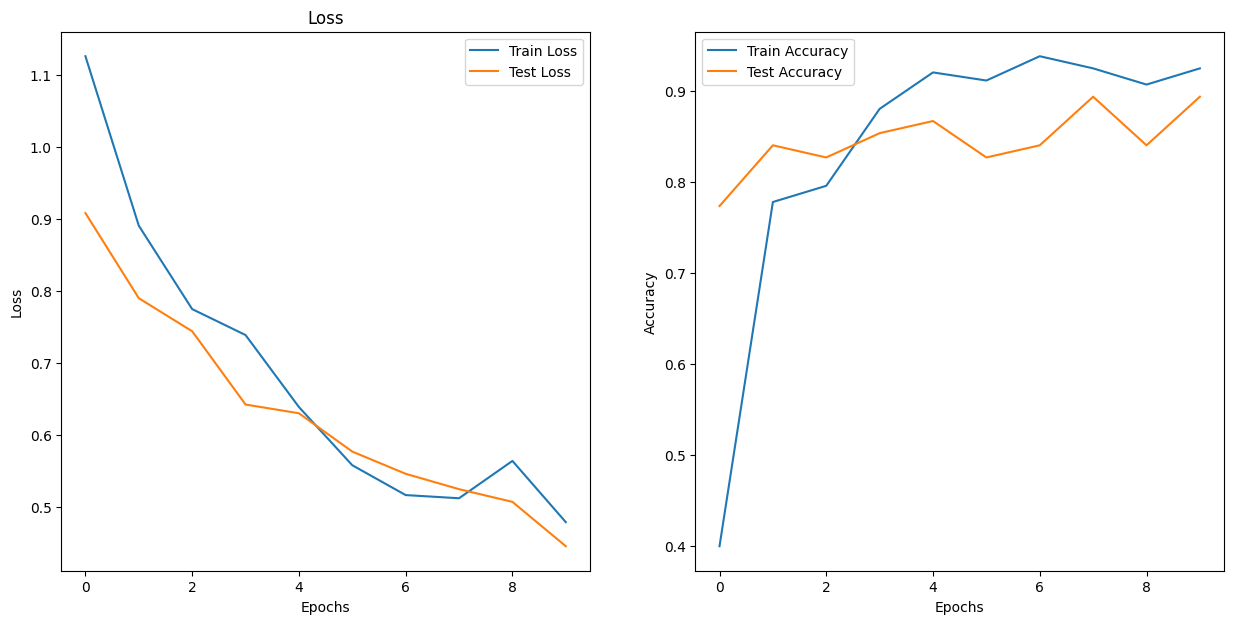

In [32]:
import matplotlib.pyplot as plt
plot_loss_curves(results)
# Model Only gets WORST wit the training haha, very weird.
# So the best possible model is with 1 epoch

# Final MODEL
To find the best possible Model. I found out my Accuracy and Precision unctions were wrong which were messing my model Accuracy up. That was good as i found out the bugs and solved them :)

In [35]:
# Manual Seed
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # Default = Best Available
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
for param in model.features.parameters():
  param.requires_grad = False
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=3,bias=True)
).to(device)
# Rewrote all the code to be faster to reiterate and reset model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
EPOCHS = 1
results = train_classification(model=model,
                              train_dataloader = train_dataloader,
                              test_dataloader = test_dataloader,
                              loss_f=loss_fn,
                              num_classes = 3,
                              epochs = 15,
                              optimizer = optimizer)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1233 | Train F1: 0.4000 | Train Acc: 0.4000 | Test Loss: 0.9103 | Test F1: 0.7067 | Test Acc: 0.7067
Epoch: 1 | Train Loss: 0.8672 | Train F1: 0.7911 | Train Acc: 0.7911 | Test Loss: 0.8250 | Test F1: 0.7733 | Test Acc: 0.7733
Epoch: 2 | Train Loss: 0.7606 | Train F1: 0.8267 | Train Acc: 0.8267 | Test Loss: 0.7683 | Test F1: 0.7600 | Test Acc: 0.7600
Epoch: 3 | Train Loss: 0.7164 | Train F1: 0.8533 | Train Acc: 0.8533 | Test Loss: 0.6642 | Test F1: 0.8267 | Test Acc: 0.8267
Epoch: 4 | Train Loss: 0.6182 | Train F1: 0.9111 | Train Acc: 0.9111 | Test Loss: 0.6603 | Test F1: 0.7867 | Test Acc: 0.7867
Epoch: 5 | Train Loss: 0.5502 | Train F1: 0.9244 | Train Acc: 0.9244 | Test Loss: 0.6087 | Test F1: 0.7867 | Test Acc: 0.7867
Epoch: 6 | Train Loss: 0.5066 | Train F1: 0.9156 | Train Acc: 0.9156 | Test Loss: 0.5712 | Test F1: 0.8133 | Test Acc: 0.8133
Epoch: 7 | Train Loss: 0.5119 | Train F1: 0.9378 | Train Acc: 0.9378 | Test Loss: 0.5441 | Test F1: 0.8267 | Test Acc:

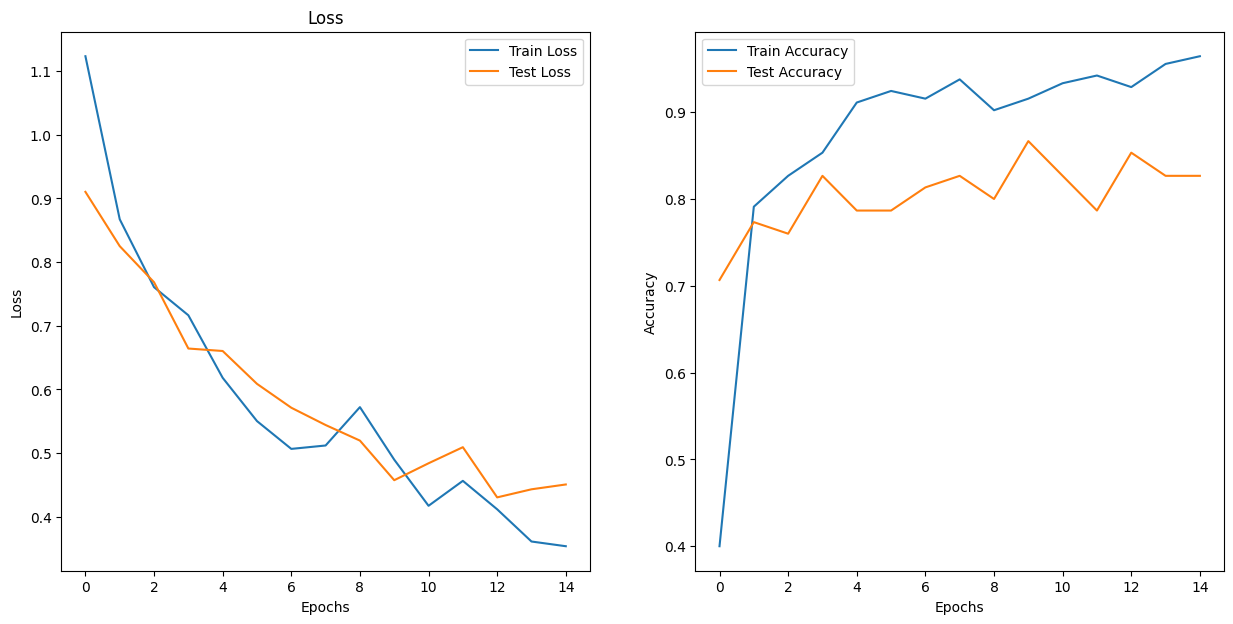

In [36]:
# INCREDIBLE RESULTS
plot_loss_curves(results)
